# Import libraries

In [34]:
# baseline cnn model for fashion mnist
import keras
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
print("All Libraries imported")

All Libraries imported


# Load dataset

In [27]:
# load train and test dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

dimension = x_train.shape[1]

num_data = 1000
frac_train = 0.7
frac_test = 0.3
x_train = x_train[0:int(frac_train*num_data)]
x_test = x_test[0:int(frac_test*num_data)]

# Normalize images

In [28]:
norm_factor = 255.
x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor
x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

# We need noisy images

In [29]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Visualize noisy images

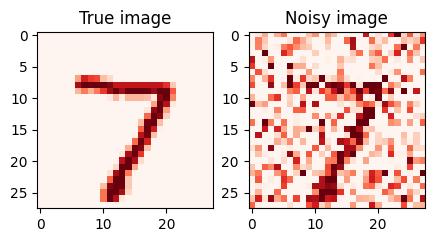

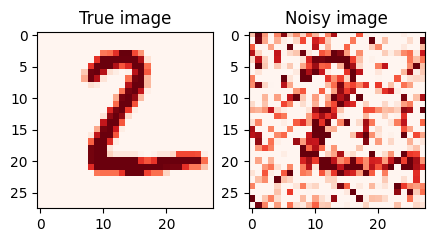

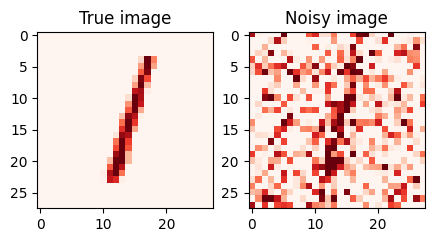

In [30]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

# Define our model - Encouder and Decoder part

In [43]:
input_img = keras.Input(shape = (dimension, dimension, 1))

x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(input_img)
x = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
encoded = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)

x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(encoded)
x = layers.UpSampling2D(size = (2, 2))(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.UpSampling2D(size = (2, 2))(x)
decoded = layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x)

# Visualize the autoencoder

In [44]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
validation_split = 0.8
#history = autoencoder.fit(x_train_noisy, x_train, epochs = 40, batch_size = 20, shuffle = True, validation_split = validation_split)
history = autoencoder.fit(x_train, x_train, epochs = 40, batch_size = 20, shuffle = True, validation_split = validation_split)

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1142 - val_loss: 0.1126
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1070 - val_loss: 0.1078
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1012 - val_loss: 0.1024
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0996 - val_loss: 0.1004
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0963 - val_loss: 0.0989
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0962 - val_loss: 0.0977
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0948 - val_loss: 0.0967
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0952 - val_loss: 0.0957
Epoch 9/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0932 - val_loss: 0.0948
Epoch 10/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0917 - val_loss: 0.0937
Epoch 11/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0892 - val_loss: 0.0936
Epoch 12/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0886 - val_loss: 0.0924
E

In [46]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [47]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

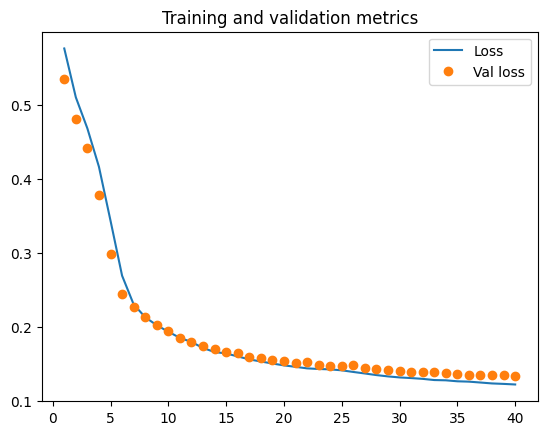

In [48]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, 'o', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('history.png')

# Predict the model

In [54]:
#all_denoised_images = autoencoder.predict(x_test_noisy)
all_images = autoencoder.predict(x_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [50]:
# Evaluate test loss

In [55]:
test_loss  = autoencoder.evaluate(x_test, x_test, batch_size = 20)
test_loss

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0779


0.07803209871053696

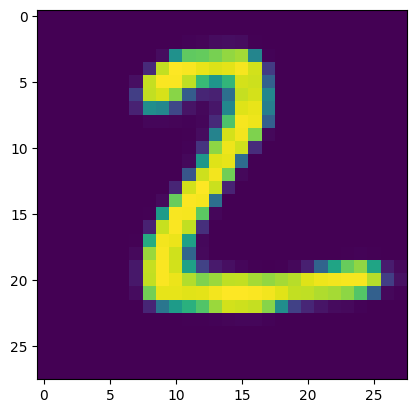

In [57]:
plt.imshow(all_images[1])

# Visualize the results

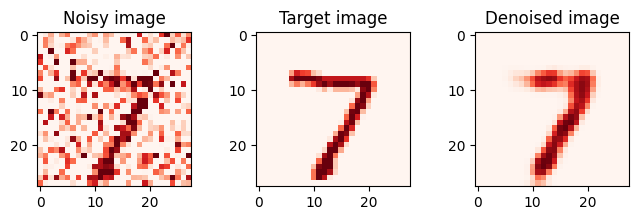

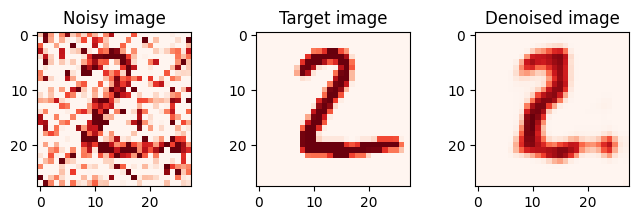

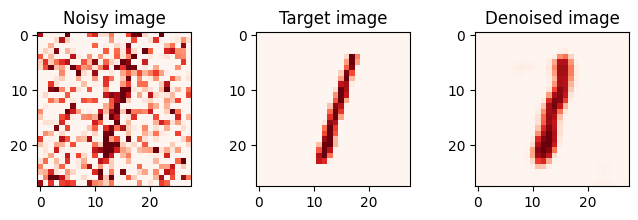

In [52]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Noisy image')
    im0 = axes[0].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Target image')
    im1 = axes[1].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[2].set_title('Denoised image')
    im2 = axes[2].imshow(all_denoised_images[i].reshape(dimension, dimension), cmap = 'Reds')
    plt.savefig(f'comparison-{i}.png')